In [1]:
import pywt
import ps_lib as ps
import scipy
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt


(512, 512, 3)
(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


Quantizing Step

In [73]:
img_path = "target-image.png"
img = ps.read_image(img_path)

def convert_YcbCr(img):
    img = 255 * img
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    y  = .299 * R + .587*G + .114*B
    cb = -.1687 * R -.3313 * G + .5 * B  # + 128 
    cr = .5 * R  -.4187 * G - .0813 * B # + 128
    return np.dstack([y, cb, cr])

def convert_RGB(img):
    Y = img[:, :, 0]
    Cb = img[:, :, 1]
    Cr = img[:, :, 2]
    R = Y + 1.402 * (Cr)
    G = Y - 0.34414 * (Cb ) -.71414 * (Cr )
    B = Y + 1.772 * (Cb )
    return np.dstack([R, G, B]) / 255


In [74]:
def get_dct_coeff(img):
    dct_coeffs = np.zeros(img.shape)

    height, width = img.shape[0], img.shape[1]

    for i in range(height // 8):
        for j in range(width // 8):
            T = [.3536, .3536, .3536, .3536, .3536, .3536, .3536, .3536, .4904, .4157, .2778, .0975, -.0975, -.2778, -.4157, -.4904, .4619, .1913, -.1913, -.4619, -.4619, -.1913, .1913, .4619, .4157, -.0975, -.4904, -.2778, .2778, .4904, .0975, -.4157, .3536, -.3536, -.3536, .3536, .3536, -.3536, -.3536, .3536, .2778, -.4904, .0975, .4157, -.4157, -.0975, .4904, -.2778, .1913, -.4619, .4619, -.1913, -.1913, .4619, -.4619, .1913, .0975, -.2778, .4157, -.4904, .4904, -.4157, .2778, -.0975]

            T = np.reshape(T, (8,8))
            img_block = img[8*i:8*i+8, 8*j:8*j+8] - 128

            # M = [26, -5, -5, -5, -5, -5, -5, 8, 64, 52, 8, 26, 26, 26, 8, -18, 126, 70, 26, 26, 52, 26, -5, -5, 111, 52, 8, 52, 52, 38, -5, -5, 52, 26, 8, 39, 38, 21, 8, 8, 0, 8, -5, 8, 26, 52, 70, 26, -5, -23, -18, 21, 8, 8, 52, 38, -18, 8, -5, -5, -5, 8, 26, 8]
            # M = np.reshape(M, (8,8))
            # matrix = np.array(data).reshape(8, 8) / 255

            D = np.round(np.array(T @ img_block @ T.T), 1)
            # print(D.shape)

            dct_coeffs[8*i:8*i+8, 8*j:8*j+8] = D      
    return dct_coeffs

def quantize_img(dct_coeffs):
    q_mat=np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])
    img_quantized = np.zeros(dct_coeffs.shape)
    
    height, width = dct_coeffs.shape[0], dct_coeffs.shape[1]

    for i in range(height // 8):
        for j in range(width // 8):
            D = dct_coeffs[8*i:8*i+8, 8*j:8*j+8]
            # print(D.shape)
            c = np.round(np.array(D / q_mat)).astype(np.int8)
            img_quantized[8*i:8*i+8, 8*j:8*j+8] = c
    return img_quantized

def unquantize_block(quantized_block):
    T = [.3536, .3536, .3536, .3536, .3536, .3536, .3536, .3536, .4904, .4157, .2778, .0975, -.0975, -.2778, -.4157, -.4904, .4619, .1913, -.1913, -.4619, -.4619, -.1913, .1913, .4619, .4157, -.0975, -.4904, -.2778, .2778, .4904, .0975, -.4157, .3536, -.3536, -.3536, .3536, .3536, -.3536, -.3536, .3536, .2778, -.4904, .0975, .4157, -.4157, -.0975, .4904, -.2778, .1913, -.4619, .4619, -.1913, -.1913, .4619, -.4619, .1913, .0975, -.2778, .4157, -.4904, .4904, -.4157, .2778, -.0975]
    q_mat=np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])
                    
    T = np.reshape(T, (8,8))
    r = q_mat * quantized_block
    N = np.round(T.T @ r @ T) + 128
    # print(N)
    return N

In [75]:
def convert_block(img):
    # assert data.dtype == np.uint8
    # data = np.asarray(data, dtype=np.int8)
    # img = img - 128   
    dct_coefficients = get_dct_coeff(img)    
    return quantize_img(dct_coefficients)

def get_jpeg(img):
    # break image into 8x8 chunks
    quantized_img = np.zeros_like(img)
    
    for c in range(3):
        quantized_img[:, :, c] = convert_block(img[:, :, c])
    
    return quantized_img

def undo_jpeg(quantized):
    height, width = quantized.shape[0], quantized.shape[1]
    img = np.zeros(quantized.shape)
    for i in range(height // 8):
        for j in range(width // 8):
            for c in range(3):
                block = quantized[8*i:8*i+8, 8*j:8*j+8, c]
                img[8*i:8*i+8, 8*j:8*j+8, c] = unquantize_block(block)
    return img

In [76]:
img_path = "target-image.png"
img = ps.read_image(img_path)
converted_img = convert_YcbCr(img)
quantized = get_jpeg(converted_img)
recovered = convert_RGB(undo_jpeg(quantized))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


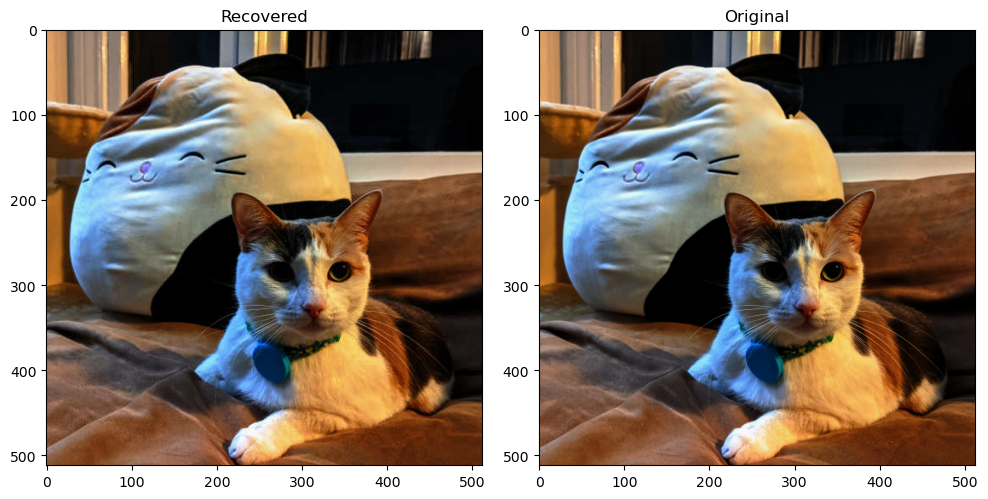

In [77]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.imshow(recovered)
ps.write_image("cat_jpeg.png", recovered)
ps.write_image("cat_jpeg_PIL.jpg", img)
plt.title('Recovered')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.imshow(img)
plt.title('Original')

plt.tight_layout()
plt.show()

In [78]:
ps.write_image("cat_ear_mine.png", recovered[200:300, 200:300])
ps.write_image("cat_ear_PIL.jpg", img[200:300, 200:300])


In [79]:
img_path = "dog.png"
img = ps.read_image(img_path)
converted_img = convert_YcbCr(img)
quantized = get_jpeg(converted_img)
recovered = convert_RGB(undo_jpeg(quantized))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


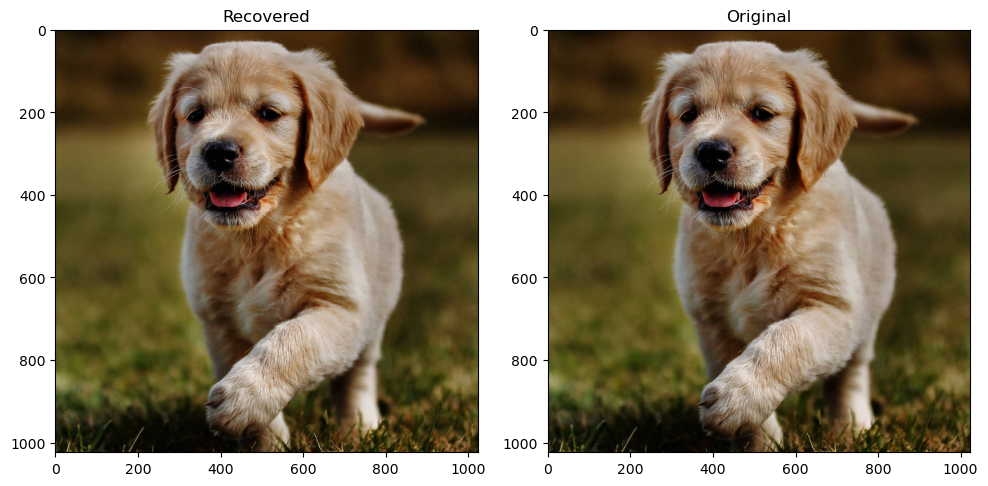

In [80]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.imshow(recovered)
ps.write_image("dog.png", recovered)
ps.write_image("dog_jpeg_PIL.jpg", img)
plt.title('Recovered')

plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.imshow(img)
plt.title('Original')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


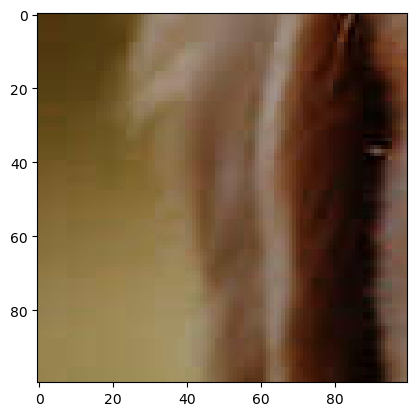

In [81]:
plt.imshow(recovered[200:300, 200:300])
plt.show()

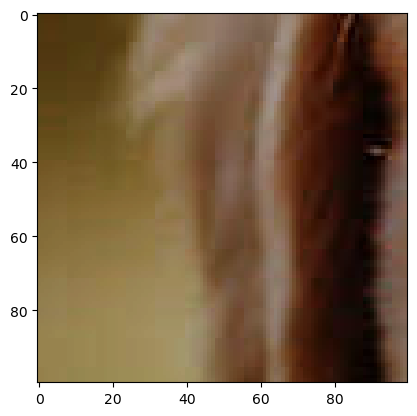

In [82]:
plt.imshow(img[200:300, 200:300])

In [83]:
# import numpy as np

# original_data = [154, 123, 123, 123, 123, 123, 123, 136, 192, 180, 136, 154, 154, 154, 136, 110, 254, 198, 154, 154, 180, 154, 123, 123, 239, 180, 136, 180, 180, 166, 123, 123, 180, 154, 136, 167, 166, 149, 136, 136, 128, 136, 123, 136, 154, 180, 198, 154, 123, 105, 110, 149, 136, 136, 180, 166, 110, 136, 123, 123, 123, 136, 154, 136]

# original_data = np.array(original_data).reshape((8, 8))

# bruh = np.dstack([original_data, original_data, original_data])
# print(bruh.shape)
# lol =get_jpeg(bruh)
# lolski = undo_jpeg(lol)

# T = [.3536, .3536, .3536, .3536, .3536, .3536, .3536, .3536, .4904, .4157, .2778, .0975, -.0975, -.2778, -.4157, -.4904, .4619, .1913, -.1913, -.4619, -.4619, -.1913, .1913, .4619, .4157, -.0975, -.4904, -.2778, .2778, .4904, .0975, -.4157, .3536, -.3536, -.3536, .3536, .3536, -.3536, -.3536, .3536, .2778, -.4904, .0975, .4157, -.4157, -.0975, .4904, -.2778, .1913, -.4619, .4619, -.1913, -.1913, .4619, -.4619, .1913, .0975, -.2778, .4157, -.4904, .4904, -.4157, .2778, -.0975]

# T = np.reshape(T, (8,8))

# M = [26, -5, -5, -5, -5, -5, -5, 8, 64, 52, 8, 26, 26, 26, 8, -18, 126, 70, 26, 26, 52, 26, -5, -5, 111, 52, 8, 52, 52, 38, -5, -5, 52, 26, 8, 39, 38, 21, 8, 8, 0, 8, -5, 8, 26, 52, 70, 26, -5, -23, -18, 21, 8, 8, 52, 38, -18, 8, -5, -5, -5, 8, 26, 8]
# M = np.reshape(M, (8,8))
# # matrix = np.array(data).reshape(8, 8) / 255

# D = np.round(np.array(T @ M @ T.T), 1) 
# print(D)


# data = np.array(original_data).reshape((8, 8)) - 128


# # Define quantization matrix for Qfactor of 50
# q_mat=np.array([[16,11,10,16,24,40,51,61],
#                 [12,12,14,19,26,58,60,55],
#                 [14,13,16,24,40,57,69,56],
#                 [14,17,22,29,51,87,80,62],
#                 [18,22,37,56,68,109,103,77],
#                 [24,35,55,64,81,104,113,92],
#                 [49,64,78,87,103,121,120,101],
#                 [72,92,95,98,112,100,103,99]])

# c = np.round(np.array(D / q_mat)).astype(np.int8)
# print(c)
# plt.imshow(lolski)


# JPEG Dimple

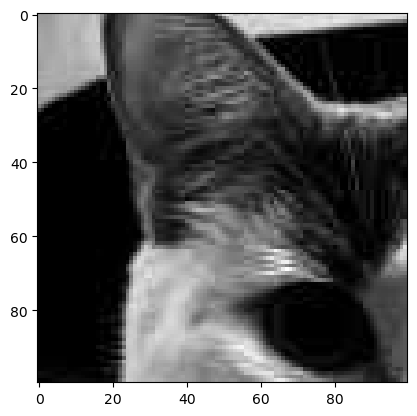

In [84]:
img_path = "cat_ear_mine.png"
img = ps.read_image(img_path)
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
y  = .299 * R + .587*G + .114*B
plt.imshow(y[:100, :100], cmap='gray')

In [ ]:
from scipy.ndimage import correlate
from scipy.signal import wiener, fftconvolve


def create_template(img_shape):
    template = np.zeros(img_shape)
    template[::8, ::8] = 1
    return template

def compute_fI(img, template):
    fI = np.zeros((8, 8))
    for u in range(8):
        for v in range(8):
            shifted_template = np.roll(template, (u, v), axis=(0, 1))
            fI[u, v] = np.sum(correlate(img, shifted_template))
    return fI

def compute_fI_fft(img, template):
    fI = np.zeros((8, 8))
    for u in range(8):
        for v in range(8):
            shifted_template = np.roll(template, (u, v), axis=(0, 1))
            fI[u, v] = fftconvolve(img, shifted_template[::-1, ::-1], mode='valid').sum()
    return fI

def compute_pce(img, template):
    # ndimage is a lot faster than correlate2d????
    # fi = correlate(img, template)

    fi = compute_fI_fft(img, template)
    fi_squared = fi **2
    max_corr = np.max(fi_squared)
    # u_hat, v_hat = np.unravel_index(np.argmax(fi), fi.shape)
    
    # Calculate the correlation energy excluding the peak
    energy = np.sum(fi_squared**2) - max_corr**2
    
    # PCE calculation
    pce = max_corr**2 / (energy / (63))
    
    return pce

In [86]:
# apply a 3 × 3 Wiener filter to each
# RGB channel and average the resulting noise residual across
# all three channels.

def compute_noise_residual(image):
    noise_residuals = []
    for i in range(3):  # Assuming the image is in RGB format
        channel = image[:, :, i]
        filtered_channel = wiener(channel, (3, 3))
        noise_residual = channel - filtered_channel
        noise_residuals.append(noise_residual)
    
    # Average the noise residuals across the three channels
    avg_noise_residual = np.mean(noise_residuals, axis=0)

    return avg_noise_residual

def average_blocks(image, block_size=32):
    height, width = image.shape
    avg_blocks = np.zeros((height // block_size + 1, width // block_size + 1))
    print(avg_blocks.shape)
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i + block_size, j:j + block_size]
            avg_blocks[i // block_size, j // block_size] = np.mean(block)
    
    return avg_blocks    

# To further suppress image content, nonoverlapping blocks of size 32 × 32 are then averaged across
# the entire image (or, optionally, a portion of the image). The
# PCE is then computed against this averaged 32×32 block and
# the corresponding template of the same size.

In [87]:
img_path = "cat_ear_mine.png"
img = ps.read_image(img_path)


avg_noise_residual = compute_noise_residual(img)

template = create_template(avg_noise_residual.shape)

# avg_noise_residual = avg_noise_residual - np.mean(avg_noise_residual)
# template = template - np.mean(template)
# avg_noise_residual = avg_noise_residual / np.sum(avg_noise_residual)
# template = template / np.sum(template)
pce = compute_pce(avg_noise_residual, template)
print(pce)


30.4570574704484


(100, 100)


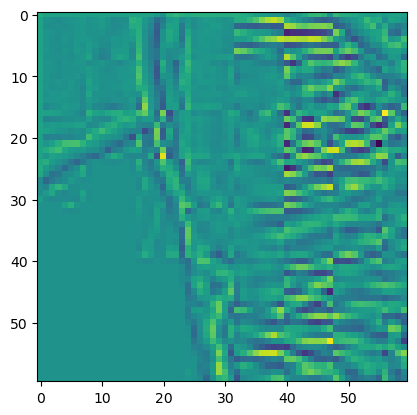

In [88]:
avg_noise_residual = compute_noise_residual(img)
print(avg_noise_residual.shape)
plt.imshow(avg_noise_residual[:60, :60])
ps.write_image("noise_residual.png", avg_noise_residual[:60, :60])
plt.show()

In [90]:
def create_per_pixel_prominence_map(image, template, window_size=32):
    height, width = image.shape
    prominence_map = np.zeros((height, width))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # define the window 
            window_row_start = max(0, i - window_size // 2)
            window_row_end = min(image.shape[0], i + window_size // 2)
            window_col_start = max(0, j - window_size // 2)
            window_col_end = min(image.shape[1], j + window_size // 2)
            
            window = image[window_row_start:window_row_end, window_col_start:window_col_end]
            
            pce_value = compute_pce(window, template)
            
            # Assign the average PCE to the prominence map
            prominence_map[i, j] = pce_value
        print(i)
    return prominence_map
template = create_template((32, 32))
prominence_map = create_per_pixel_prominence_map(avg_noise_residual, template)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


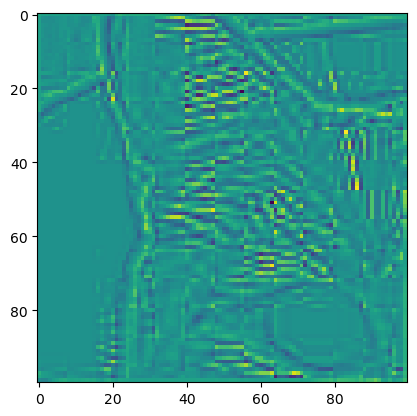

In [97]:
plt.imshow(avg_noise_residual)

In [103]:
print(np.max(prominence_map))

290.5866431731298


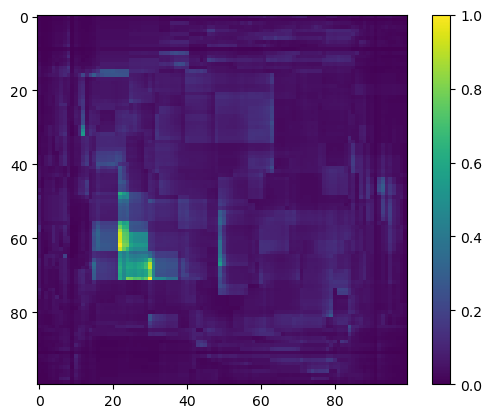

In [104]:
prominence_map = (prominence_map - np.min(prominence_map)) / (np.max(prominence_map) - np.min(prominence_map))
prominence_map
plt.imshow(prominence_map)
plt.colorbar()
plt.show()
# ps.write_image("dimple_map.png", prominence_map)

In [ ]:
plt.imshow(img)

# JPEG 2000 stuff

# Computing the DWT

In [ ]:
H = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, -1, -1, -1, -1],
    [1, 1, -1, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, -1, -1],
    [1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, -1]
]).T


# H = np.array([])

# Normalize the matrix
norm = np.linalg.det(H)
# print(row_norms)
col_norms = np.linalg.norm(H, axis=0, keepdims=True)
# print(col_norms)
np.set_printoptions(precision=3, suppress=True)
print(H)
normalized_H = H / norm

# print(normalized_H)
row = data[0]
bruh = normalized_H @ np.array(row)
print(bruh)


In [ ]:
H = [[.5, .5, 0, 0, 0, 0, 0, 0], [.5, -.5, 0, 0, 0, 0, 0, 0], [0, 0, .5, .5, 0, 0, 0, 0], [0, 0, .5, -.5, 0, 0, 0, 0], [0, 0, 0, 0, .5, .5, 0, 0], [0, 0, 0, 0, .5, -.5, 0, 0], [0, 0, 0, 0, 0, 0, .5, .5], [0, 0, 0, 0, 0, 0, .5, -.5]]
H = np.reshape(H, (8, 8))
norm_factor = np.linalg.norm(H, axis=1)
H = H / norm_factor
print(H)


print(H @ row)
print(pywt.dwt(row, 'haar'))

In [ ]:
H = np.array([[.5, .5, 0, 0], [.5, -.5, 0, 0], [0, 0, .5, .5], [0, 0, .5, -.5]])
print(H @ np.array([1, 3, 3, 4]) * np.sqrt(2))

In [ ]:
print(pywt.dwt([1, 2], 'db1'))

# 2D wavelet transform

In [7]:
def gen_harr_matrix(N: int):
    if N <= 1 or  (N & (N - 1)) != 0:
        print("N is not a multiple of 2 zodie")
        return
    
    harr = np.zeros((N, N))
    for i in range(0, N, 2):
        harr[i, i:i+2] = [1, 1]
        harr[i+1, i:i+2] = [1, -1]

    # normalizing the harr matrix so it's consistent with pwt
    return harr / np.linalg.norm(harr, axis=1)

def gen_harr_inverse(N: int):
    return np.linalg.inv(gen_harr_matrix(N))


In [8]:
zodie = np.random.randint(0, 100, size=(512, 512)) # np.array([[1,3, 1, 52], [1,3, 133, 2], [9,56, 32, 1], [1,30, 10, 57]])


def get_2d_wavelet_transform(data):
    H = gen_harr_matrix(len(data))

    row_stuff = H @ data

    # permute the rowwws

    cA_row, cD_row = row_stuff[::2, :], row_stuff[1::2, :]
    # print(cA, '\n\n',cD)
    col_stuff = H @ cA_row.T

    cA, cV = col_stuff[::2, :].T, col_stuff[1::2, :].T
    col_stuff2 = H @ cD_row.T


    cH, cD = col_stuff2[::2, :].T, col_stuff2[1::2, :].T


    # cA_pywt, (cH_pywt, cV_pywt, cD_pywt) = pywt.dwt2(data, 'haar', axes =(0, 1))

    # assert len(np.flatnonzero(~np.isclose(cA, cA_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cH, cH_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cV, cV_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cD, cD_pywt))) == 0
    # assert len(np.flatnonzero(cV - cV_pywt)) == 0
    # assert len(np.flatnonzero(cD - cD_pywt)) == 0
    # assert len(np.flatnonzero(cH - cH_pywt)) == 0

    # return pywt.dwt2(data, 'haar', axes =(0, 1))

    return cA, (cH, cV, cD)

cA, (cH, cV, cD) = get_2d_wavelet_transform(zodie)

def get_inv_wavelet_transform(cA, cH, cV, cD):

    h_inv = gen_harr_inverse(len(cA) * 2)
    col_stuff2 = np.zeros_like(np.vstack([cH, cH]))
    col_stuff2[::2, :] = cH.T
    col_stuff2[1::2, :] = cD.T

    cD_row = (h_inv @ col_stuff2).T


    col_stuff = np.zeros((cH.shape[0]*2, cH.shape[1]))
    col_stuff[::2, :] = cA.T
    col_stuff[1::2, :] = cV.T

    cA_row = (h_inv @ col_stuff).T

    row_stuff = np.zeros_like(np.vstack([cA_row, cA_row]))
    row_stuff[::2, :] = cA_row
    row_stuff[1::2, :] = cD_row
    
    data = h_inv @ row_stuff

    # CHANGE
    # data = pywt.idwt2((cA, (cH, cV, cD)), 'haar')

    return data


assert len(np.flatnonzero(~np.isclose(zodie, get_inv_wavelet_transform(cA, cH, cV, cD)))) == 0

# JPEG 2000 the image

In [9]:
bruh = np.zeros((242, 241, 2)).T
print(bruh.shape)

(2, 241, 242)


In [15]:
def get_step_size(R, i, c, f):
    base_step = 2 ** (R - c + i) * (1 + f/(2**11))
    return base_step

def quantize_blur(base_step, iterations, blur):
    d = base_step / 2**iterations
    blur_quantize = np.sign(blur) * np.floor(np.abs(blur) / d)
    return blur_quantize

def quantize_detail(base_step, mode, curr_iter, coeff):
    if mode == 'diagonal':
        d = base_step / (2**(curr_iter-2))
    else:
        # should be the horizontal/vertical one
        d = base_step / (2**(curr_iter-1))
    detail_quantize = np.sign(coeff) * np.floor(np.abs(coeff) / d)
    return detail_quantize

def undo_quantize_blur(base_step, iterations, quantized_blur):
    d = base_step / 2**iterations
    return quantized_blur * d

def undo_quantize_detail(base_step, curr_iter, mode, quantized_blur):
    if mode == 'diagonal':
        d = base_step / (2**(curr_iter-2))
    else:
        # should be the horizontal/vertical one
        d = base_step / (2**(curr_iter-1))
    return quantized_blur * d
# quantize(8, 3, 8.5, 8, blocks)

In [16]:
def multiple_wavelet(img, iterations):
    blur = img
    blocks = {}
    for curr_iter in range(iterations):
        cAs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cHs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cVs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cDs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        for i in range(3):
            cA, (cH, cV, cD) = get_2d_wavelet_transform(blur[:, :, i])
            cAs[:, :, i] = cA
            cHs[:, :, i] = cH
            cVs[:, :, i] = cV
            cDs[:, :, i] = cD

        blocks[str(curr_iter)] = {}
        blocks[str(curr_iter)]['cHs'] = cHs
        blocks[str(curr_iter)]['cVs'] = cVs
        blocks[str(curr_iter)]['cDs'] = cDs
        blocks[str(curr_iter)]['cAs'] = cAs
        
        blur = cAs
    blocks['blur'] = blur
    blocks['iterations'] = iterations
    return blocks




In [49]:
def quantize_multiple_wavelet(wavelet_dict, R=None, c=None, f=None):
    assert R is not None
    assert c is not None
    assert f is not None
    
    wavelet_quantized = {}
    iterations = wavelet_dict['iterations']
    for iteration in range(iterations):
        wavelet_quantized[str(iteration)] = {}
        base_step_size = get_step_size(R, iteration+1, c, f)
        # this can be cleaner for sure
        horizontal_detail = np.copy(wavelet_dict[str(iteration)]['cHs'])
        vertical_detail = np.copy(wavelet_dict[str(iteration)]['cVs'])
        diagonal_detail = np.copy(wavelet_dict[str(iteration)]['cDs']) 
        
        horizontal_detail_quanitzed = quantize_detail(base_step_size, 'horizontal', iteration+1, horizontal_detail)
        vertical_detail_quanitzed = quantize_detail(base_step_size, 'vertical', iteration+1, vertical_detail)
        diagonal_detail_quanitzed = quantize_detail(base_step_size, 'diagonal', iteration+1, diagonal_detail)

        wavelet_quantized[str(iteration)]['cHs'] = horizontal_detail_quanitzed 
        wavelet_quantized[str(iteration)]['cVs'] = vertical_detail_quanitzed
        wavelet_quantized[str(iteration)]['cDs'] = diagonal_detail_quanitzed

    base_step_size_blur = get_step_size(R, iterations, c, f)
    wavelet_quantized['blur'] = quantize_blur(base_step_size_blur, iterations, np.copy(wavelet_dict['blur']))
    wavelet_quantized['iterations'] = wavelet_dict['iterations']
    wavelet_quantized['R'] = R
    wavelet_quantized['c'] = c
    wavelet_quantized['f'] = f
    
    return wavelet_quantized

def get_inv_3d(cAs, cHs, cVs, cDs):
    img = np.zeros((cAs.shape[0]*2, cAs.shape[1]*2, 3))
    for i in range(3):
        img[:, :, i] = get_inv_wavelet_transform(cAs[:, :, i], cHs[:, :, i], cVs[:, :, i], cDs[:, :, i])
    return img

In [62]:
from PIL import Image

def upscale_img_nearest(img, shape):
    row_ratio, col_ratio = img.shape[0] / shape[0], img.shape[1] / shape[1]
    row_idx = (np.floor(np.arange(shape[0]) * row_ratio)).astype(int)
    col_idx = (np.floor(np.arange(shape[1]) * col_ratio)).astype(int)
    return img[row_idx][:, col_idx]

yerp


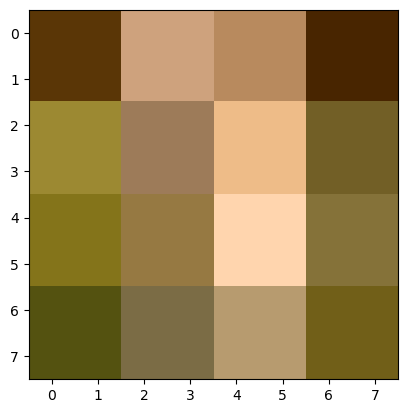

8


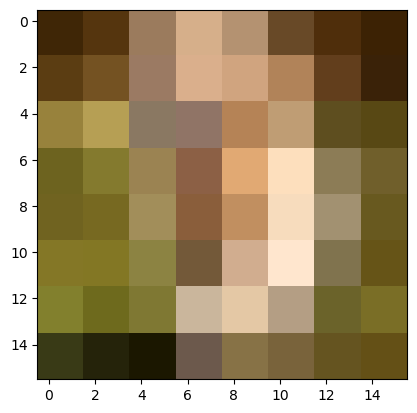

7


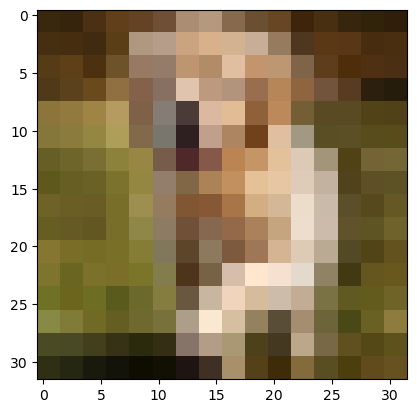

6


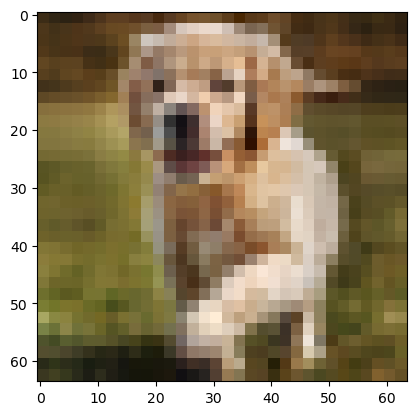

5


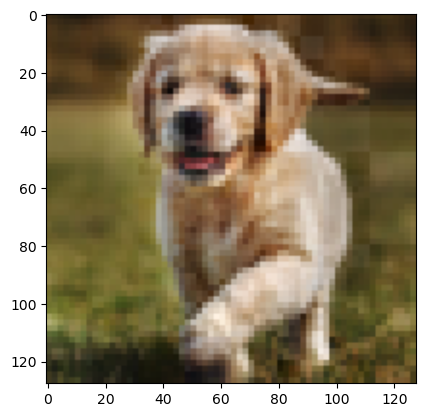

4


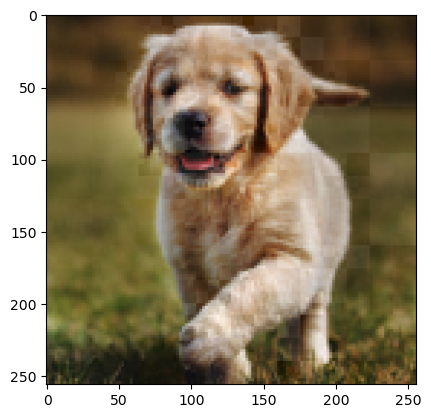

3


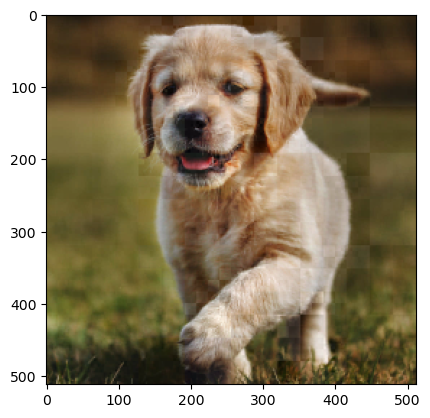

2


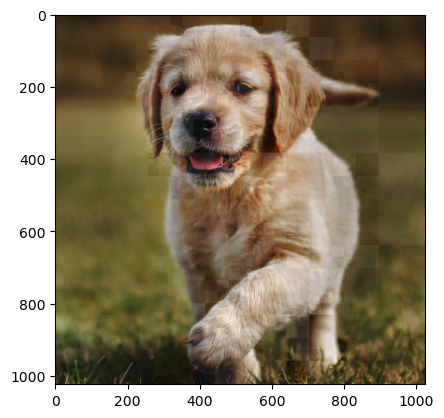

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


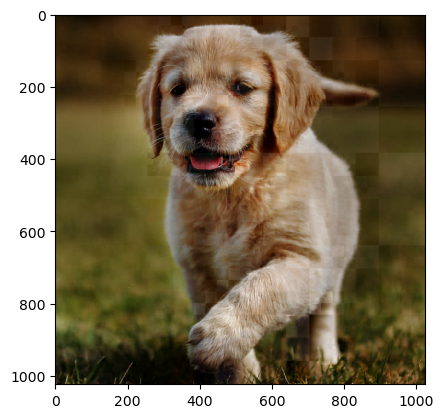

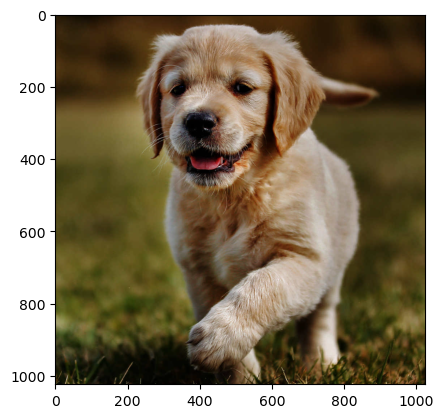

In [101]:
CAT_IMAGE_SHAPE = (512, 512, 3)
def recover_img(wavelet_dict, isquantized=False):
    curr_cA = wavelet_dict['blur']
    if isquantized:
        print("yerp")
        R, iterations, c, f = wavelet_dict['R'], wavelet_dict['iterations'], wavelet_dict['c'], wavelet_dict['f']
        base_step = get_step_size(R, iterations, c, f)
        brodie = undo_quantize_blur(base_step, iterations, curr_cA)
        curr_cA = np.copy(brodie)

    for i in range(wavelet_dict['iterations']-1, -1, -1):
        cHs = np.copy(wavelet_dict[str(i)]['cHs'])
        cVs = np.copy(wavelet_dict[str(i)]['cVs'])
        cDs = np.copy(wavelet_dict[str(i)]['cDs'])

        zero = np.zeros(curr_cA.shape)
            
        img = get_inv_3d(curr_cA, zero, zero, zero)
        
        # normalize the image
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        plt.imshow(img)
        plt.show()
        img = upscale_img_nearest(img, CAT_IMAGE_SHAPE)
        ps.write_image(f"cat_{i}.png", img)
        if isquantized:
            R, c, f = wavelet_dict['R'], wavelet_dict['c'], wavelet_dict['f']
            print(i+1)
            base_step = get_step_size(R, i+1, c, f)
            cHs = undo_quantize_detail(base_step, i+1, 'horizontal', cHs)
            cVs = undo_quantize_detail(base_step, i+1, 'verticals', cVs)
            cDs = undo_quantize_detail(base_step, i+1, 'diagonals', cDs)
            
        curr_cA = get_inv_3d(np.copy(curr_cA), cHs, cVs, cDs)
    return curr_cA

iterations = 8
img_path = "dog.png"
img = np.array(ps.read_image(img_path))

bruh = multiple_wavelet(img, iterations)
# CHANGE R LATER
wavelet_quantized = quantize_multiple_wavelet(bruh, R=3, c=12, f=8)
recovered_img = recover_img(wavelet_quantized, True)
# recovered_img = (recovered_img - np.min(recovered_img)) / (np.max(recovered_img) - np.min(recovered_img))

ps.write_image("dog_jpeg2000_8.png", recovered_img)

plt.imshow(recovered_img)
plt.show()
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


yerp


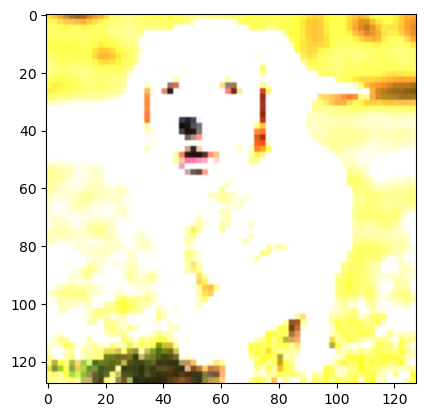

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4


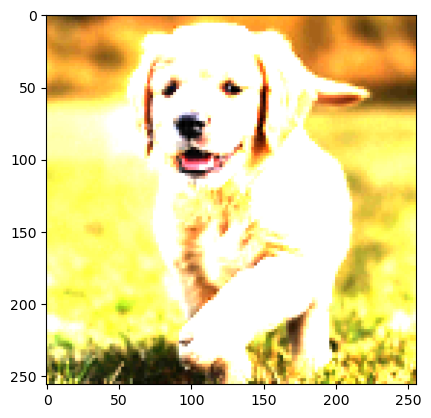

3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


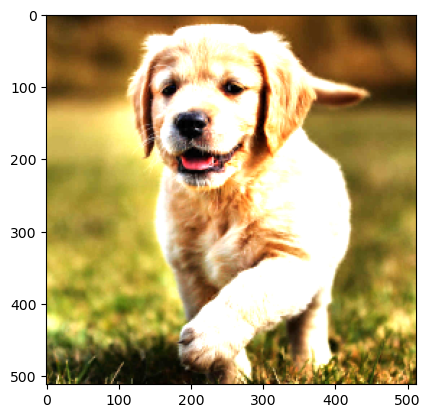

2


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


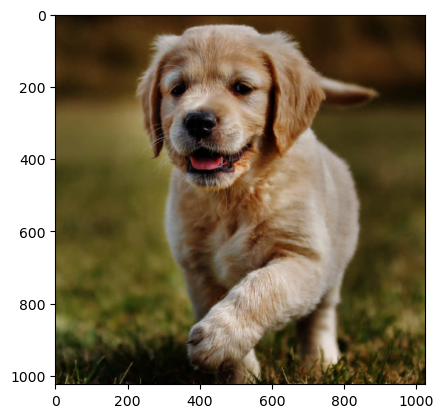

1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


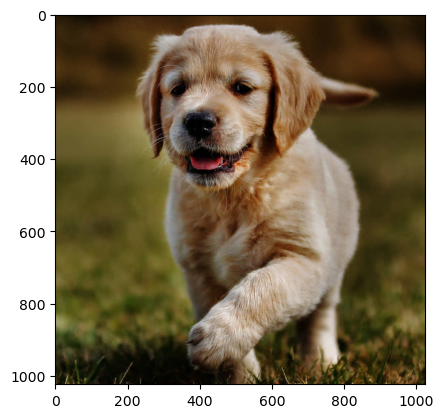

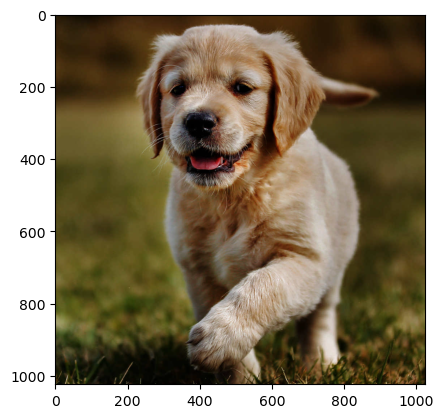

In [43]:
iterations = 4
img_path = "dog.png"
img = np.array(ps.read_image(img_path))

bruh = multiple_wavelet(img, iterations)
# CHANGE R LATER
wavelet_quantized = quantize_multiple_wavelet(bruh, R=3, c=12, f=8)
recovered_img = recover_img(wavelet_quantized, True)
# recovered_img = (recovered_img - np.min(recovered_img)) / (np.max(recovered_img) - np.min(recovered_img))

ps.write_image("dog_jpeg2000.png", recovered_img)

plt.imshow(recovered_img)
plt.show()
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


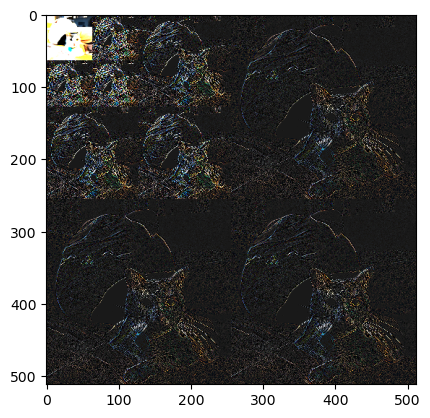

In [106]:

img_path = "target-image.png"
img = np.array(ps.read_image(img_path))

blocks = multiple_wavelet(img, 3)

# do the beautiful reconstruction thingy

wavelet_domain_img = np.zeros(img.shape)
# wavelet_domain_img[img.shape[0] // 2**2: 2*img.shape[0] // 2**2, img.shape[0] // 2**2: 2*img.shape[0] // 2**2, : ] = blocks['1']['cAs']

for i in range(blocks['iterations']):

    wavelet_domain_img[img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), : ] = (blocks[str(i)]['cDs']+.01) * 10

    wavelet_domain_img[: img.shape[0] // 2**(i + 1), img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), : ] = (blocks[str(i)]['cDs']+.01)* 10
    
    wavelet_domain_img[img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), 0: img.shape[0] // 2**(i + 1), : ] = (blocks[str(i)]['cDs']+.01)* 10
wavelet_domain_img[:img.shape[0] // 2**(i + 1), :img.shape[0] // 2**(i + 1), : ] = blocks['blur']

# wavelet_domain_img = (wavelet_domain_img - np.min(wavelet_domain_img)) * (np.max(wavelet_domain_img) - np.min(wavelet_domain_img))
plt.imshow(wavelet_domain_img)
plt.show()

ps.write_image("cat_imgs.png", wavelet_domain_img)

(array([9.00000e+00, 3.60000e+01, 1.11000e+02, 6.27000e+02, 1.89030e+04,
        7.58229e+05, 6.11200e+03, 2.06600e+03, 3.33000e+02, 6.00000e+00]),
 array([-13.39708838, -10.79609012,  -8.19509186,  -5.59409361,
         -2.99309535,  -0.39209709,   2.20890117,   4.80989943,
          7.41089768,  10.01189594,  12.6128942 ]),
 <BarContainer object of 10 artists>)

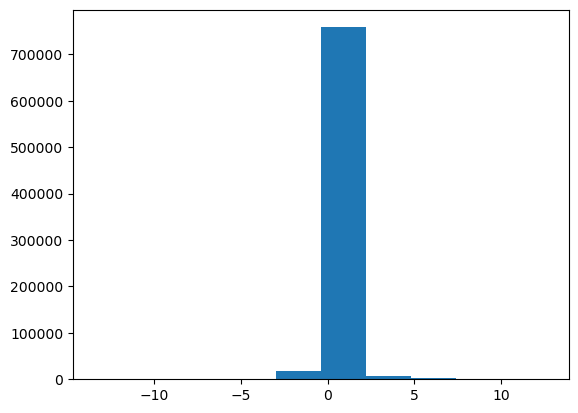

In [107]:
plt.hist(wavelet_domain_img.flatten())

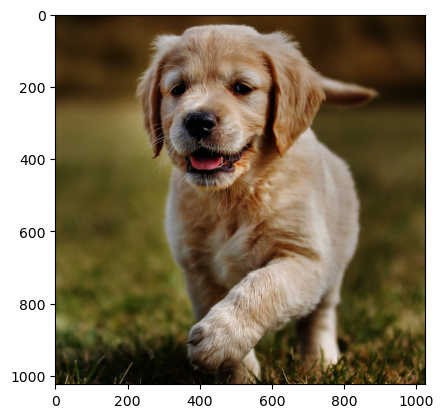

In [40]:

img_path = "dog.png"
img = np.array(ps.read_image(img_path))
img.shape
dog = img[:1024, 800:800+1024, :]
plt.imshow(dog)
plt.show()
ps.write_image("dog.png", dog)

In [ ]:
ps

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0}


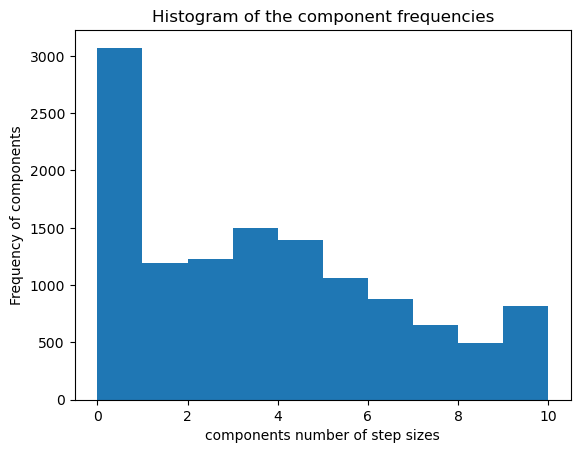

In [118]:
plt.hist(quantized_blur.flatten())
plt.xlabel("components number of step sizes")
plt.ylabel("Frequency of components")
plt.title("Histogram of the component frequencies")
print(set(quantized_blur.flatten()))

In [117]:
print(np.flatnonzero(quantized_blur < 0))

[]


In [109]:
blocks = multiple_wavelet(img, 3)

blur = blocks['blur']

base_step_size = get_step_size(8, 3, 8.5, 8)
quantized_blur = quantize_blur(base_step_size, 3, blur)
# quantized_blur = quantize(8, 3, 8.5, 8, blocks)
# zero = np.zeros(blur.shape)
# # Set the detail coefficients of the higher levels to None to keep only low-frequency components

# low_res_image_actual = pywt.idwt2([blur, (zero, zero, zero)], 'haar', axes=(0, 1))

# recovered = undo_quantize_blur(8, 3, 8.5, 8, quantized_blur)
# plt.imshow((low_res_image_actual - np.min(low_res_image_actual)) / (np.max(low_res_image_actual) - np.min(low_res_image_actual)))

# plt.show()
# low_res_image_recovered = pywt.idwt2([recovered, (zero, zero, zero)], 'haar', axes=(0, 1))

# plt.imshow((low_res_image_recovered - np.min(low_res_image_recovered)) / (np.max(low_res_image_recovered) - np.min(low_res_image_recovered)))
# plt.show()

# zodie = (low_res_image_recovered - np.min(low_res_image_recovered)) / (np.max(low_res_image_recovered) - np.min(low_res_image_recovered))
# ps.write_image("letsgooo.png", zodie)

# zodie2 = (low_res_image_actual - np.min(low_res_image_actual)) / (np.max(low_res_image_actual) - np.min(low_res_image_actual))
# ps.write_image("letsgooo2.png", zodie2)

# # plt.imshow(blur)
# # plt.show()

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(recovered)


1.1092549019607845
-0.13615686274509803


(array([2.86500e+03, 6.62848e+05, 6.69646e+05, 6.73634e+05, 4.24372e+05,
        3.00648e+05, 2.91980e+05, 1.11283e+05, 8.36900e+03, 8.30000e+01]),
 array([-0.13615686, -0.01161569,  0.11292549,  0.23746667,  0.36200784,
         0.48654902,  0.6110902 ,  0.73563137,  0.86017255,  0.98471373,
         1.1092549 ]),
 <BarContainer object of 10 artists>)

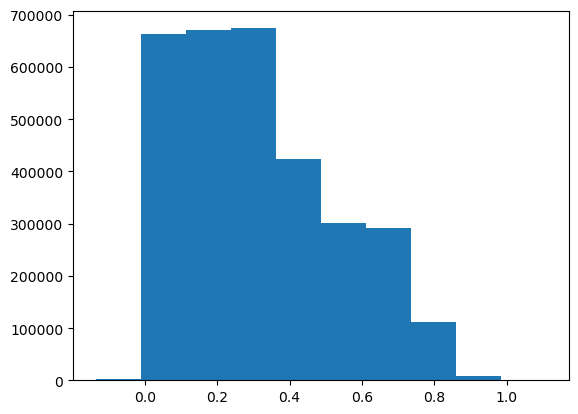

In [105]:
print(np.max(recovered))
print(np.min(recovered))

plt.hist(recovered.flatten())

In [ ]:
blocks['0']['cHs'].shape

In [ ]:
plt.imshow((blocks['0']['cDs']+.05) * 10)

In [ ]:
blocks['0']['cDs'].shape

In [ ]:
img_path = "target-image.png"
img = np.array(ps.read_image(img_path))

cAs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cHs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cVs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cDs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))

for i in range(3):
    cA, (cH, cV, cD) = get_2d_wavelet_transform(img[:, :, i])
    cAs[:, :, i] = cA
    cHs[:, :, i] = cH
    cVs[:, :, i] = cV
    cDs[:, :, i] = cD

reconstructed_img = np.zeros(img.shape)
for i in range(3):
    reconstructed_img[:, :, i] = get_inv_wavelet_transform(cAs[:, :, i], cHs[:, :, i], cVs[:, :, i], cDs[:, :, i])

plt.imshow(reconstructed_img)
plt.show()


cA, (cH, cV, cD) =pywt.dwt2(img, 'haar', axes=(0,1))
plt.imshow(cA)
plt.show()
plt.imshow(cAs)
plt.show()


In [ ]:
# zodie = np.array([[1,3], [2, 3]])
# print(zodie, '\n')

# H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
# # norm_factor = np.linalg.norm(H, axis=1)
# # print(norm_factor)


# # multiplying zodie by transpose gives
# # har wavelets in terms f 
# print(H @ zodie)

# print(pywt.dwt(zodie, 'db1', axis=0))


In [ ]:
# doing it ourselves

zodie = np.array([[1,3], [2, 3]])

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
# axis zero
# print(H @ zodie)
row_cA, row_cD = H @ zodie
print(row_cA, row_cD)

col_cA, col_cD = H @ row_cA.T 
print(col_cA, col_cD)


col_cA, col_cD = H @ row_cD.T 
print(col_cA, col_cD)

# LL, (cDh, cd)
print(pywt.dwt2(zodie, 'db1'))


In [ ]:
# zodie = np.array([[151, 123], [566, 122]])




# row_cA, row_cD = pywt.dwt(zodie, 'db1', axis=0)
# # downsample, keep even index cols
# # brodie = np.row_stack([row_cA, row_cD])
# print(row_cA, row_cD,'\n')

# col_cA, col_cD = pywt.dwt(row_cA, 'db1', axis=1)
# # brodie = np.column_stack([row_cA, col_cD])[::2, :]
# print(col_cA, col_cD)

# print("yooooo\n\n")
# cols_cA, cols_cD = pywt.dwt(row_cD, 'db1', axis=1)
# print(cols_cA, cols_cD)


# print(pywt.dwt2(zodie, 'db1'))



In [ ]:
# print(pywt.dwt(np.array([1,3,3,4]).T, 'db1'))

# H = [.5, .5, .5, .5, .5, .5, -.5, -.5, np.sqrt(2)/2, -np.sqrt(2)/2, 0, 0, 0, 0, np.sqrt(2)/2, -np.sqrt(2)/2]
# H = np.reshape(H, (4,4))
# row_norms = np.linalg.norm(H, axis=1, keepdims=True)

# H = H / row_norms

# print(H)
# print(H @ np.array([1, 2, 3, 4]))
